In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import jax
import jax.numpy as jnp
from jax import device_put
import flax

import numpy as np

In [3]:
%load_ext autoreload
%autoreload 1

%aimport main
%aimport train
%aimport data

from flows.glow import GLOW

In [11]:
config_dict = {
        'image_path': "../../datasets/stickman/e",
        'ext': 'png',
        'train_split': 0.6,
        'image_size': 32,
        'num_channels': 3,
        'num_bits': 5,
        'batch_size': 10,
        'K': 16,
        'L': 3,
        'nn_width': 512, 
        'learn_top_prior': True,
        'sampling_temperature': 0.7,
        'init_lr': 1e-3,
        'num_epochs': 13,
        'num_warmup_epochs': 1,
        'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
        'num_save_epochs': 5,
    }

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

In [5]:
random_key = jax.random.PRNGKey(0)

In [6]:
model = GLOW(K=config_dict['K'],
             L=config_dict['L'], 
             nn_width=config_dict['nn_width'], 
             learn_top_prior=config_dict['learn_top_prior'])


shape = (config_dict['batch_size'],config_dict['image_size'],config_dict['image_size'],config_dict['num_channels'])

In [64]:
with open('weights/model_epoch=080.weights', 'rb') as f:
#     params = model.init(random_key, jnp.zeros(shape))
    params = flax.serialization.from_bytes(params, f.read())

In [21]:
from functools import partial
from train import sample
from data import postprocess

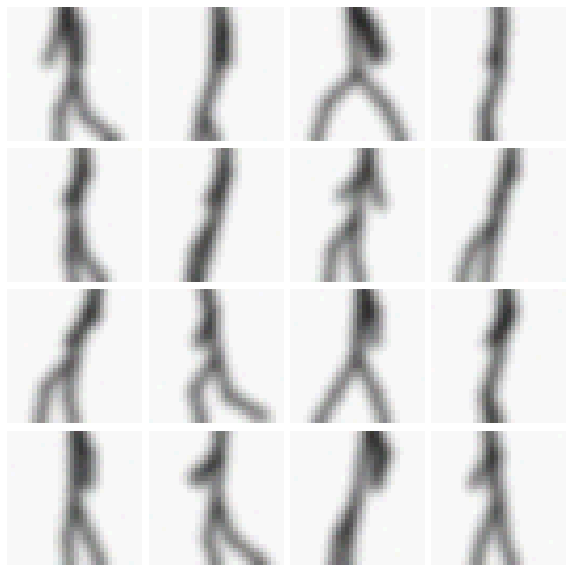

In [47]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]));

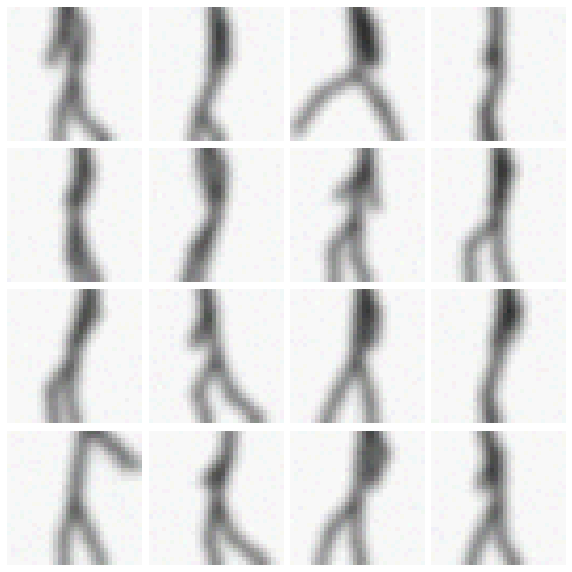

In [39]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]));

In [49]:
train_ds, val_ds = data.setup_data(config_dict,show_grid=False)
del train_ds

20000 training images
2000 training steps per epoch


In [13]:
from utils import plot_image_grid 

def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(postprocess(batch, config_dict["num_bits"]), title="original")
    plot_image_grid(rec, title="reconstructions")

def interpolate(model, params, batch, num_samples=16, key=random_key):
    global config_dict
    i1, i2 = jax.random.choice(key, jnp.array(range(batch.shape[0])), shape=(2,), replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

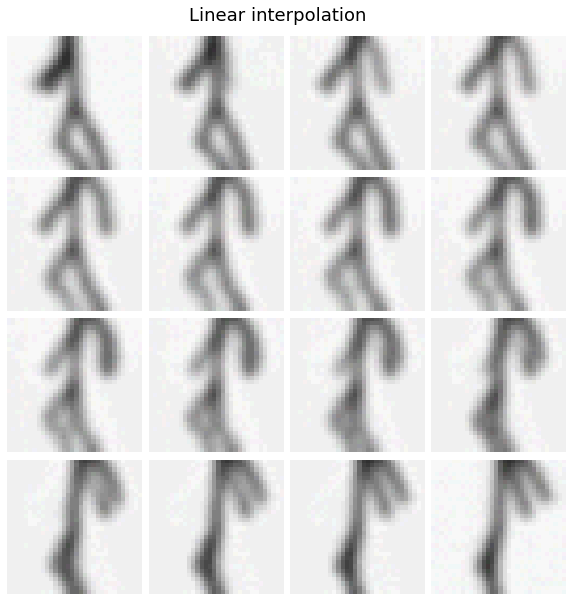

In [63]:
batch = next(val_ds)
interpolate(model, params, batch)

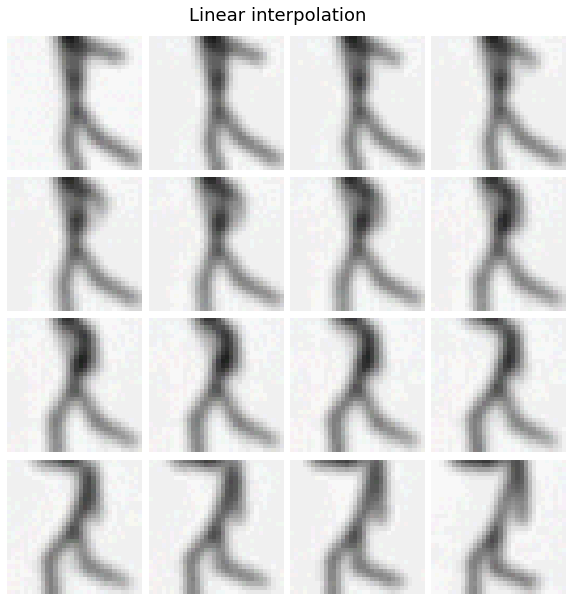

In [59]:
batch = next(val_ds)
interpolate(model, params, batch)

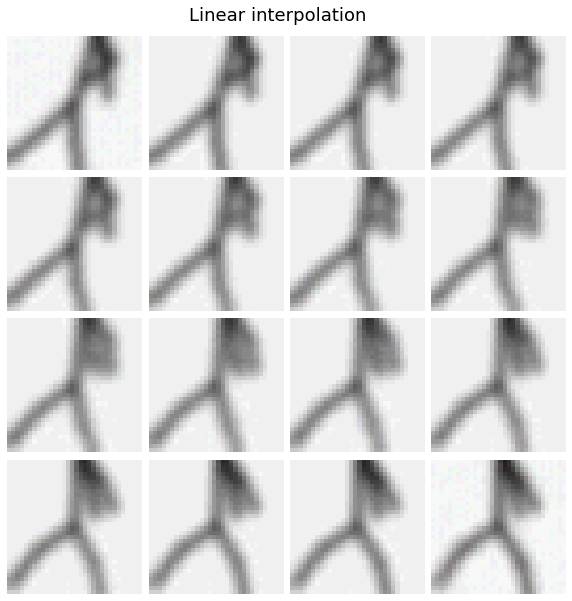

In [26]:
batch = next(val_ds)
interpolate(model, params, batch)

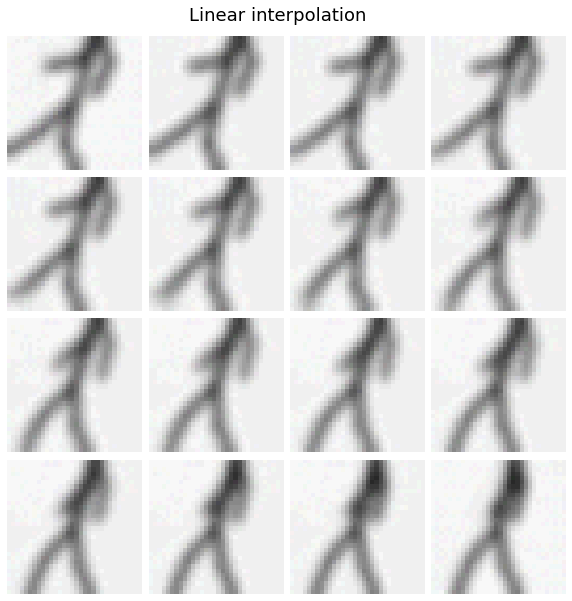

In [42]:
batch = next(val_ds)
interpolate(model, params, batch)

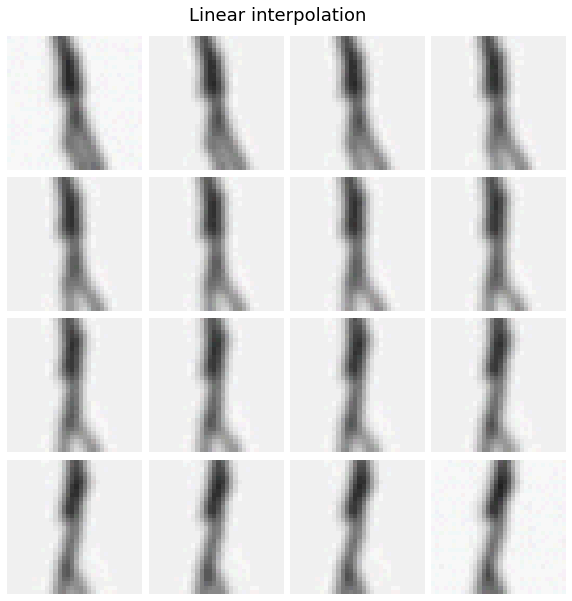

In [43]:
batch = next(val_ds)
interpolate(model, params, batch)

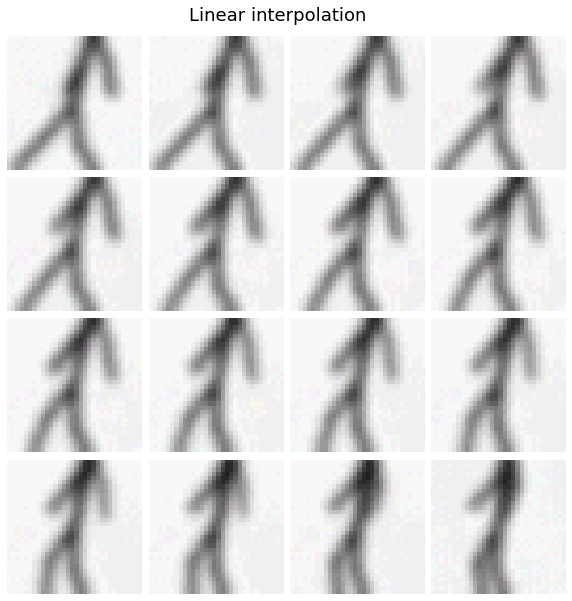

In [44]:
batch = next(val_ds)
interpolate(model, params, batch)

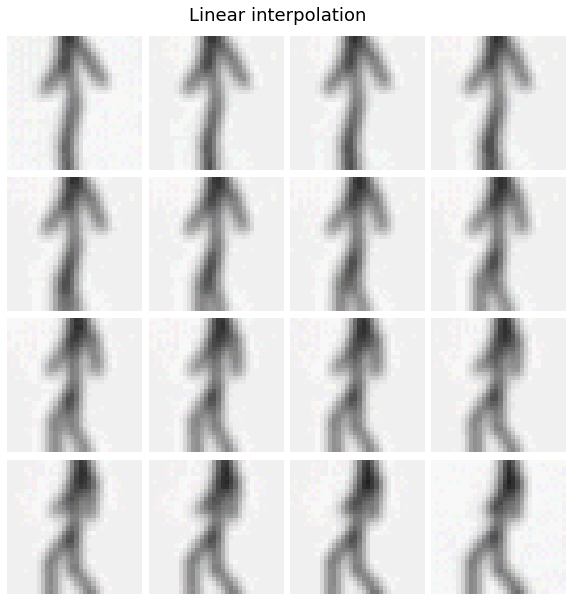

In [45]:
batch = next(val_ds)
interpolate(model, params, batch)

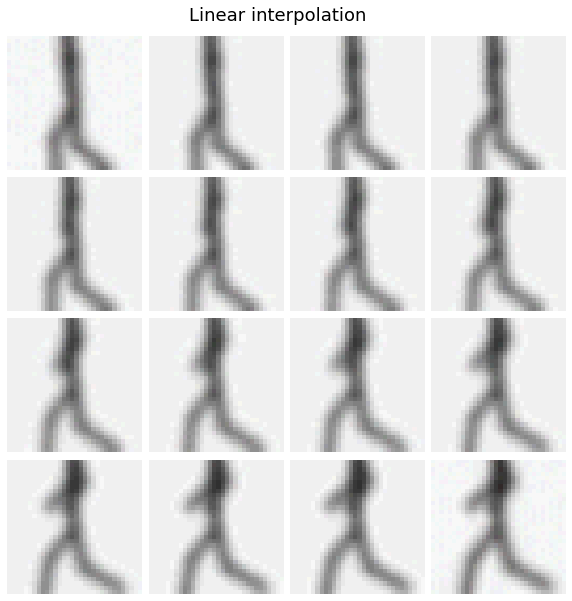

In [31]:
batch = next(val_ds)
interpolate(model, params, batch)

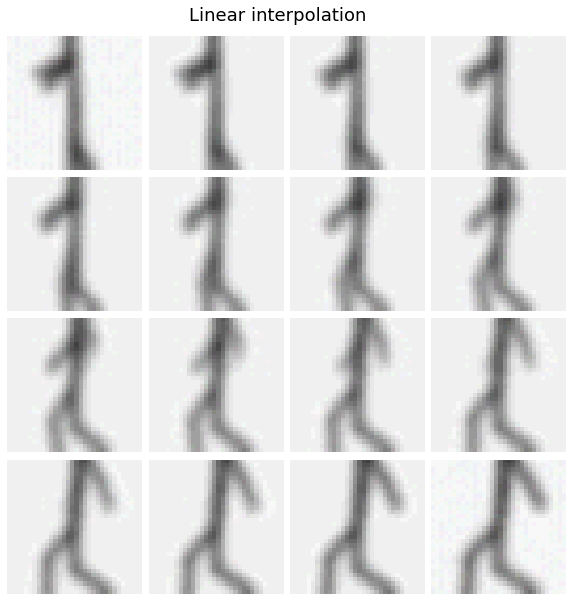

In [32]:
batch = next(val_ds)
interpolate(model, params, batch)

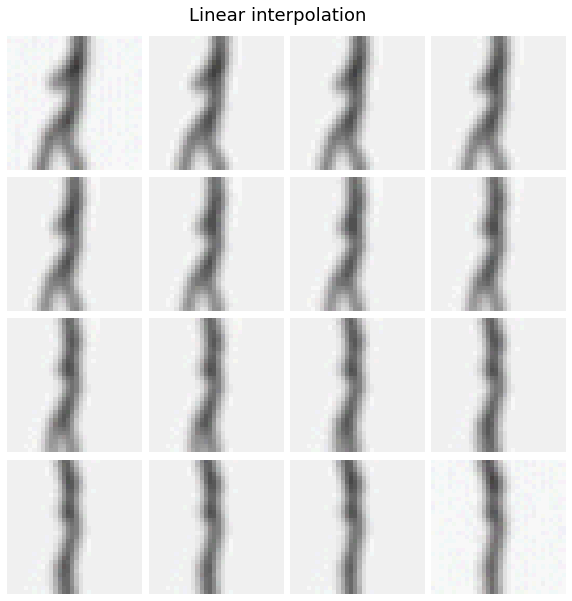

In [37]:
batch = next(val_ds)
interpolate(model, params, batch)